In [1]:
# import sys
# scripts_path = "/kaggle/input/commonscripts"
# if not scripts_path in sys.path:
#     sys.path.append(scripts_path)
# from read_data import *



In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
import cv2
import datetime


%load_ext tensorboard

import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [3]:
# Data preprocessing function
def preprocess_spectrogram(spectrogram):
    is_valid = True
    spectrogram_std = np.std(spectrogram)
    if spectrogram_std == 0.0:
        is_valid = False
    else:
        # Normalize the spectrogram
        spectrogram = (spectrogram - np.mean(spectrogram)) / spectrogram_std
    # Add channel dimension
    spectrogram = np.expand_dims(spectrogram, axis=-1)
    return spectrogram, is_valid

In [4]:
filenames_train = glob.glob('/kaggle/input/ne-mo-2-summer-challenge/train/spectrograms/*/*.jpeg')
filenames_other = glob.glob('/kaggle/input/ne-mo-2-summer-challenge/other/spectrograms/*.jpeg')
filenames_other = filenames_other
filenames_val = glob.glob('/kaggle/input/ne-mo-2-summer-challenge/test/spectrograms/*.jpeg')

# X = np.zeros((len(filenames_train) + len(filenames_other), 48, 256), np.float32)
# X_val = np.zeros((len(filenames_val), 48, 256))
# y = np.zeros((len(filenames_train) + len(filenames_other)))

df_columns = ['row_id', 'class_id', 'filename', 'spectrogram', 'spectrogram_pre', 'wav', 'valid']
data_df = pd.DataFrame(columns=df_columns)
other_df = pd.DataFrame(columns=df_columns)
val_df = pd.DataFrame(columns=df_columns)

for i, filename in enumerate(filenames_train):
    path_split = filename.split(os.path.sep)
#     print("\n".join(path_split))
    class_id = path_split[-2].replace("bird", "")
    row_id = path_split[-1].replace(".jpeg", "")
#     print(class_id.replace("bird", ""))
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img_pre, is_valid = preprocess_spectrogram(img)
#     X[i, :, :] = img
#     y[i] = class_id
    if is_valid:
        data_df.loc[i] = {'row_id': int(row_id), 'class_id': int(class_id), 'filename': filename, 'spectrogram': img, 'spectrogram_pre': img_pre, 'wav': None, 'valid': is_valid}
    
for i, filename in enumerate(filenames_other):
    path_split = filename.split(os.path.sep)
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img_pre, is_valid = preprocess_spectrogram(img)
#     X[i + len(filenames_train), :, :] = img
#     y[i + len(filenames_train)] = 5
    if is_valid:
        other_df.loc[i] = {'row_id': int(row_id), 'class_id': int(class_id), 'filename': filename, 'spectrogram': img, 'spectrogram_pre': img_pre, 'wav': None, 'valid': is_valid}
    
for i, filename in enumerate(filenames_val):
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    img_pre, is_valid = preprocess_spectrogram(img)
    path_split = filename.split(os.path.sep)
#     X_val[i, :, :] = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    val_df.loc[i] = {'row_id': int(row_id), 'filename': filename, 'spectrogram': img, 'spectrogram_pre': img_pre, 'wav': None, 'valid': is_valid}

In [5]:
print('Train:')
data_df.info()
print('\nOther:')
other_df.info()
print('\nVal:')
val_df.info()

Train:
<class 'pandas.core.frame.DataFrame'>
Index: 1906 entries, 0 to 1908
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   row_id           1906 non-null   int64 
 1   class_id         1906 non-null   int64 
 2   filename         1906 non-null   object
 3   spectrogram      1906 non-null   object
 4   spectrogram_pre  1906 non-null   object
 5   wav              0 non-null      object
 6   valid            1906 non-null   bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 106.1+ KB

Other:
<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 0 to 14
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   row_id           15 non-null     int64 
 1   class_id         15 non-null     int64 
 2   filename         15 non-null     object
 3   spectrogram      15 non-null     object
 4   spectrogram_pre  15 non-null     object
 5   w

In [6]:
# Define the model
def create_model(num_classes):
    model = models.Sequential([
        # Input layer - spectrogram size is 48x256x1 (grayscale)
        layers.Input(shape=(48, 256, 1)),
        
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Fourth convolutional block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model



# Training setup
def train_model(model, train_data, train_labels, val_data, val_labels, log_dir, class_weight, epochs=500, batch_size=32):
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Add callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
    ]
     # Train the model
    history = model.fit(
        train_data,
        train_labels,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(val_data, val_labels),
        callbacks=callbacks,
        verbose=0,
        class_weight=class_weight
    )
    
    return history   

In [7]:
from keras.applications import EfficientNetV2B0 as efficient_net


# Example parameters
num_classes = 6

# Create the model
model = create_model(num_classes)
# model = efficient_net(
#     include_top=True,
#     weights=None,
#     input_tensor=None,
#     input_shape=(48, 256, 1),
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     include_preprocessing=True,
#     )

# Print model summary
# model.summary()

# Example of how to prepare and load data
"""
# Load your data here
train_data = ...  # Shape: (num_samples, 48, 256)
train_labels = ...  # Shape: (num_samples,)
val_data = ...  # Shape: (num_val_samples, 48, 256)
val_labels = ...  # Shape: (num_val_samples,)

# Preprocess the data
train_data = np.array([preprocess_spectrogram(spec) for spec in train_data])
val_data = np.array([preprocess_spectrogram(spec) for spec in val_data])

# Train the model
history = train_model(model, train_data, train_labels, val_data, val_labels)
"""


# X_processed, X_valid = zip(*[preprocess_spectrogram(X[i]) for i in range(X.shape[0])])
# X_valid = np.array(X_valid)
# X_processed = np.array(X_processed)[X_valid]
# y_processed = y[X_valid]

# X_val_processed, X_val_valid = zip(*[preprocess_spectrogram(X_val[i]) for i in range(X_val.shape[0])])
# X_val_valid = np.array(X_val_valid)
# X_val_processed = np.array(X_val_processed)


train_df, test_df = train_test_split(
    data_df,
    random_state=42,
#     shuffle=True,
    test_size=0.25
)

train_other_df, test_other_df = train_test_split(
    other_df,
    random_state=42,
#     shuffle=True,
    test_size=0.25
)
    
                                            

In [8]:
train_df.head().columns
# %whos


Index(['row_id', 'class_id', 'filename', 'spectrogram', 'spectrogram_pre',
       'wav', 'valid'],
      dtype='object')

In [9]:
# %tensorboard --logdir logs/fit
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
class_weight = {0: 1.,
                1: 1.,
                2: 1.,
                3: 1.,
                4: 1.,
                5: 1.,
               }

# Train the model
history = train_model(
    model, 
    np.stack(pd.concat([train_df, train_other_df])['spectrogram_pre'], 1).reshape(-1, 48, 256, 1), 
    np.stack(pd.concat([train_df, train_other_df])['class_id'], 0),
    np.stack(pd.concat([test_df, test_other_df])['spectrogram_pre'], 1).reshape(-1, 48, 256, 1), 
    np.stack(pd.concat([test_df, test_other_df])['class_id'], 0),
    log_dir=log_dir,
    class_weight=class_weight,
#     batch_size = 4
)

I0000 00:00:1730244911.243895      65 service.cc:145] XLA service 0x7a2e8c016d30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730244911.243974      65 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730244917.076404      65 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_7', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1730244917.085742      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [10]:
history.history

{'accuracy': [0.21597221493721008,
  0.24236111342906952,
  0.2708333432674408,
  0.28263887763023376,
  0.2770833373069763,
  0.2923611104488373,
  0.3125,
  0.3326388895511627,
  0.31805557012557983,
  0.3375000059604645,
  0.3687500059604645,
  0.4131944477558136],
 'loss': [9.872323989868164,
  2.5269649028778076,
  1.6378178596496582,
  1.5955090522766113,
  1.5687733888626099,
  1.5599948167800903,
  1.5127651691436768,
  1.5052356719970703,
  1.4737355709075928,
  1.473726511001587,
  1.4175180196762085,
  1.3412550687789917],
 'val_accuracy': [0.22661122679710388,
  0.234927237033844,
  0.20374220609664917,
  0.20166319608688354,
  0.2141372114419937,
  0.2141372114419937,
  0.22245322167873383,
  0.19542619585990906,
  0.18711018562316895,
  0.2058212012052536,
  0.23284822702407837,
  0.20166319608688354],
 'val_loss': [3.053640365600586,
  1.7656899690628052,
  1.7987470626831055,
  1.7799288034439087,
  1.6817076206207275,
  1.6673840284347534,
  1.6418591737747192,
  1.649

In [11]:
pred_val_raw = model.predict(np.stack(val_df['spectrogram_pre'], 1).reshape(-1, 48, 256, 1))
pred_val = np.argmax(pred_val_raw, 1)
columns = ['row_id', 'bird0', 'bird1', 'bird2', 'bird3', 'bird4', 'other']

pred_val_ohe = []
for i, filename in enumerate(filenames_val):
    pred = pred_val[i]
    row_id = int(filename.split(os.path.sep)[-1].split('.')[0])
    
    new = np.zeros(len(columns))
    new[pred + 1] = 1
    new[0] = row_id
    
    pred_val_ohe.append(new)
    
pred_val_ohe = np.array(pred_val_ohe, dtype=np.uint16)
pred_test_raw = model.predict(np.stack(test_df['spectrogram_pre'], 1).reshape(-1, 48, 256, 1))

pred_test = np.argmax(pred_test_raw, 1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


[0.22661122679710388, 0.234927237033844, 0.20374220609664917, 0.20166319608688354, 0.2141372114419937, 0.2141372114419937, 0.22245322167873383, 0.19542619585990906, 0.18711018562316895, 0.2058212012052536, 0.23284822702407837, 0.20166319608688354]


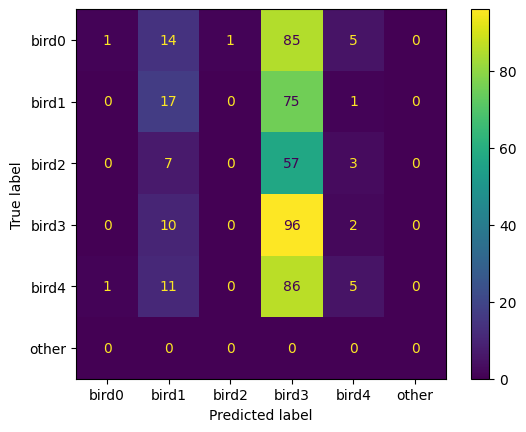

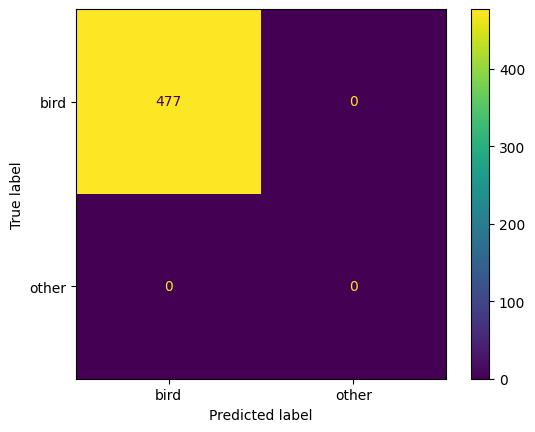

In [12]:

cm = confusion_matrix(np.stack(test_df['class_id']).astype(np.int64), pred_test, labels=range(6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=columns[1:])
disp.plot()

cm2 = confusion_matrix((np.stack(test_df['class_id'])>4).astype(np.int64), pred_test>4, labels=range(2))
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=['bird', 'other'])
disp2.plot()

print(history.history['val_accuracy'])

In [13]:
import IPython

false_predictions_indices = np.nonzero(np.multiply(np.stack(test_df['class_id']) == 5, pred_test != np.stack(test_df['class_id'])))[0]
print(false_predictions_indices)




for false_prediction_index in false_predictions_indices:
    
    path = test_df.iloc[false_prediction_index]['filename']
    print(path, f"Correct class: {np.stack(test_df['class_id'])[false_prediction_index]}, class assigned: {pred_test[false_prediction_index]}")
    IPython.display.display(IPython.display.Audio(path.replace('spectrograms', 'clips').replace('.jpeg', '.ogg')))
    IPython.display.display(IPython.display.Image(path, width=500))






[]


In [14]:
df = pd.DataFrame(pred_val_ohe, columns=columns)
print(df.sort_values(by='row_id').sum())
df.sort_values(by='row_id').to_csv('submission.csv', index=False)
model.save_weights('model.weights.h5')

row_id    1665725
bird0          15
bird1         140
bird2           4
bird3         884
bird4          52
other           0
dtype: uint64
